Estimated head count: -68
Number of detected heads (above threshold): 0


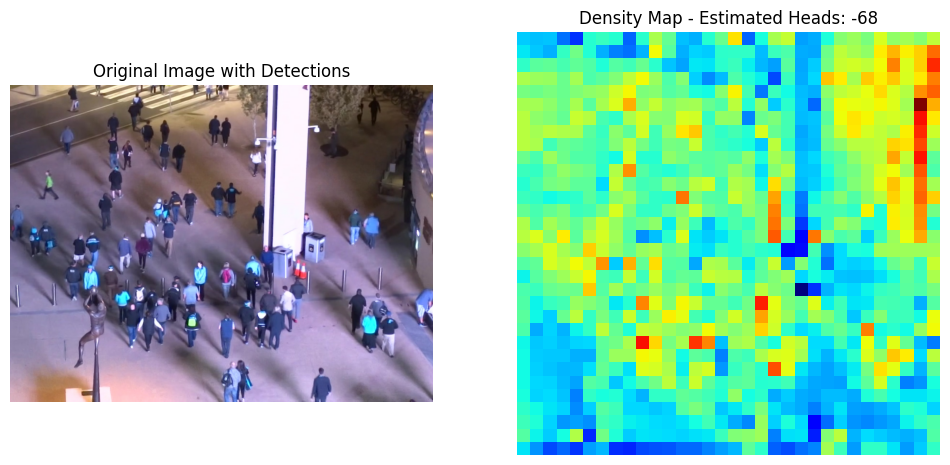

In [ ]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from skimage.feature import peak_local_max  # Import for peak detection

# Step 1: Define Fuss-Free Net
class FussFreeNet(nn.Module):
    def __init__(self):
        super(FussFreeNet, self).__init__()

        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(64, 1, kernel_size=1)  # Final density map output layer

        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(2, 2)

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.pool(x)

        x = self.relu(self.conv2(x))
        x = self.pool(x)

        x = self.relu(self.conv3(x))
        x = self.pool(x)

        x = self.conv4(x)
        return x  # Output density map

# Step 2: Initialize the model and load weights (if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = FussFreeNet().to(device)

# Optionally, load pre-trained weights if available
# model.load_state_dict(torch.load('fussfree_net_weights.pth', map_location=device))
model.eval()

# Step 3: Define image transformation
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((256, 256)),  # Resize based on the model input requirements
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # ImageNet normalization
])

# Step 4: Load and preprocess your image
image_path = '000003.jpg'  # Replace with the path to your image
image = Image.open(image_path).convert("RGB")

# Store original image dimensions
original_width, original_height = image.size

input_image = transform(image).unsqueeze(0).to(device)

# Step 5: Run inference to get the density map
with torch.no_grad():
    density_map = model(input_image)

# Step 6: Post-process density map to count heads
# Convert density map to CPU and get the numpy array
density_map = density_map.squeeze().cpu().numpy()

# Sum over all pixel values in the density map to count heads
head_count = np.sum(density_map)
print(f"Estimated head count: {head_count:.0f}")

# **Added Feature: Detect heads and mark with red dots on original image**

# Set threshold value
threshold = 0.5  # You can adjust this value

# Detect peaks in the density map
coordinates = peak_local_max(density_map, min_distance=5, threshold_abs=threshold)
print(f"Number of detected heads (above threshold): {len(coordinates)}")

# Map coordinates back to original image size

# Get density map dimensions (after pooling layers)
density_map_height, density_map_width = density_map.shape

# Compute scaling factors to map coordinates back to original image size
scale_x = original_width / density_map_width
scale_y = original_height / density_map_height

# Map coordinates to original image size
mapped_coordinates = []
for coord in coordinates:
    y, x = coord  # Note: coordinates are in (row, col) format
    original_x = x * scale_x
    original_y = y * scale_y
    mapped_coordinates.append((original_x, original_y))

# Step 7: Visualize density map and original image with detections
plt.figure(figsize=(12, 6))

# Original image
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title("Original Image with Detections")
plt.axis("off")

# Plot red dots where heads are detected
for coord in mapped_coordinates:
    x, y = coord  # Coordinates are in (x, y) format
    plt.plot(x, y, 'ro', markersize=4)

# Density map
plt.subplot(1, 2, 2)
plt.imshow(density_map, cmap='jet', interpolation='nearest')
plt.title(f"Density Map - Estimated Heads: {head_count:.0f}")
plt.axis("off")

plt.show()
